# Exploring Data and Testing Onset Detection Functions

This notebook is designed to explore `.wav` files containing shrimp clicks related to feeding activity. As part of the Exploratory Data Analysis (EDA), we will visualize both the time-domain signals and their corresponding spectrograms for selected signal segments.

Additionally, we will apply the detection functions implemented in **`detect_clicks.py`**, including Spectral Flux (SF), High-Frequency Content (HFC), Weighted Phase Deviation (WPD), and Complex Domain (CD). The objective is to analyze the results and fine-tune detection parameters such as thresholds.

This notebook serves as a critical step in the development and adjustment of the detection pipeline, enabling the refinement of parameter settings and the verification of detection logic.



In [1]:
# === Path and system setup ===
from pathlib import Path
import sys

# === Step 1: Manually set project root ===
PROJECT_ROOT = Path().resolve().parents[1]

# === Step 2: Add project root to sys.path if not already present ===
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# === Libraries ===
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib import rc

import librosa
from librosa.feature import melspectrogram
from scipy.signal import spectrogram, filtfilt, ShortTimeFFT, stft, windows
import soundfile as sf

# === Project imports ===
from src.features.extract_features import compute_spectral_flux, compute_hfc, compute_wpd, compute_cd
from src.visualization.plot_setup import configure_plots, plot_spectrogram
from src.utils.paths import get_wav_path

# === Plotting configuration ===
_ = configure_plots()


In [2]:
from src.data.preprocess import get_sample_rate, read_audio_segment

# Set path to raw wav files
filename = "210323_001_0001_Tr4.WAV"
file_path = get_wav_path("Freq_Feeding", "8x_Rep01", filename)

# Get audio file information to extract the sample rate
fs = get_sample_rate(file_path)

print(f'Sample Rate: {fs/1000} kHz')

start_time = 15    # Start time in seconds
duration = 15  # Duration in seconds

# Calculate the starting sample and the number of samples to read
start_sample = int(start_time * fs)
num_samples = int(duration * fs)

x = read_audio_segment(file_path, start_sample, num_samples)

t = np.arange(num_samples)/fs

Sample Rate: 192.0 kHz


In [3]:
# === Load and Inspect Configuration Parameters ===
from src.config.config_loader import load_config
from src.config.config_helpers import get_band_limits, get_dsp_params

# Load parameters from config/config.yaml (or fallback to defaults)
config = load_config()

# Extract band limits (low and high frequencies for SF and HFC)
f_low, f_high = get_band_limits(config)

# Extract DSP-related parameters (e.g., window durations and threshold)
params = get_dsp_params(config)
short_term = params["short_term"]
mid_term = params["mid_term"]
threshold = params["threshold"]

# === Print loaded values for debugging/validation ===
print("✓ Configuration successfully loaded:")
print(f"  - Frequency band: low = {f_low} Hz, high = {f_high} Hz")
print(f"  - Short-term duration: {short_term*1e3:.1f} ms")
print(f"  - Mid-term duration: {mid_term:.1f} s")
print(f"  - Detection threshold: {threshold:.3f}")

✓ Configuration successfully loaded:
  - Frequency band: low = 5000 Hz, high = 22050 Hz
  - Short-term duration: 5.0 ms
  - Mid-term duration: 1.0 s
  - Detection threshold: 0.005


In [4]:
# Compute spectrogram
time_resolution = short_term
W = int(time_resolution * fs)
nfft = W

# Define the Hann window as a vector
window = windows.hann(W, sym=False)

 # Compute STFT
stft_transform = ShortTimeFFT(mfft=nfft, hop=W,  win=window, fft_mode='onesided', fs  = fs)
STFT_oneside = stft_transform.stft(x, p0=0, p1=num_samples//W, k_offset=0)
Sxx = np.abs(STFT_oneside)

# One-sided Frequency Vector
freqs_onesided = np.linspace(0,fs/2,nfft//2 + 1)

idx_fselection = (freqs_onesided < f_high) & (freqs_onesided >= 1e3) #&

# Compute time vector (aligned with STFT frames)
num_frames = Sxx.shape[1]  # Number of time frames
tt = np.arange(num_frames) * (W / fs)

print(f'Sxx shape: {Sxx.shape}. f vector len: {len(freqs_onesided)}. nfft/2+1 = {nfft//2+1}')

Sxx shape: (481, 3000). f vector len: 481. nfft/2+1 = 481


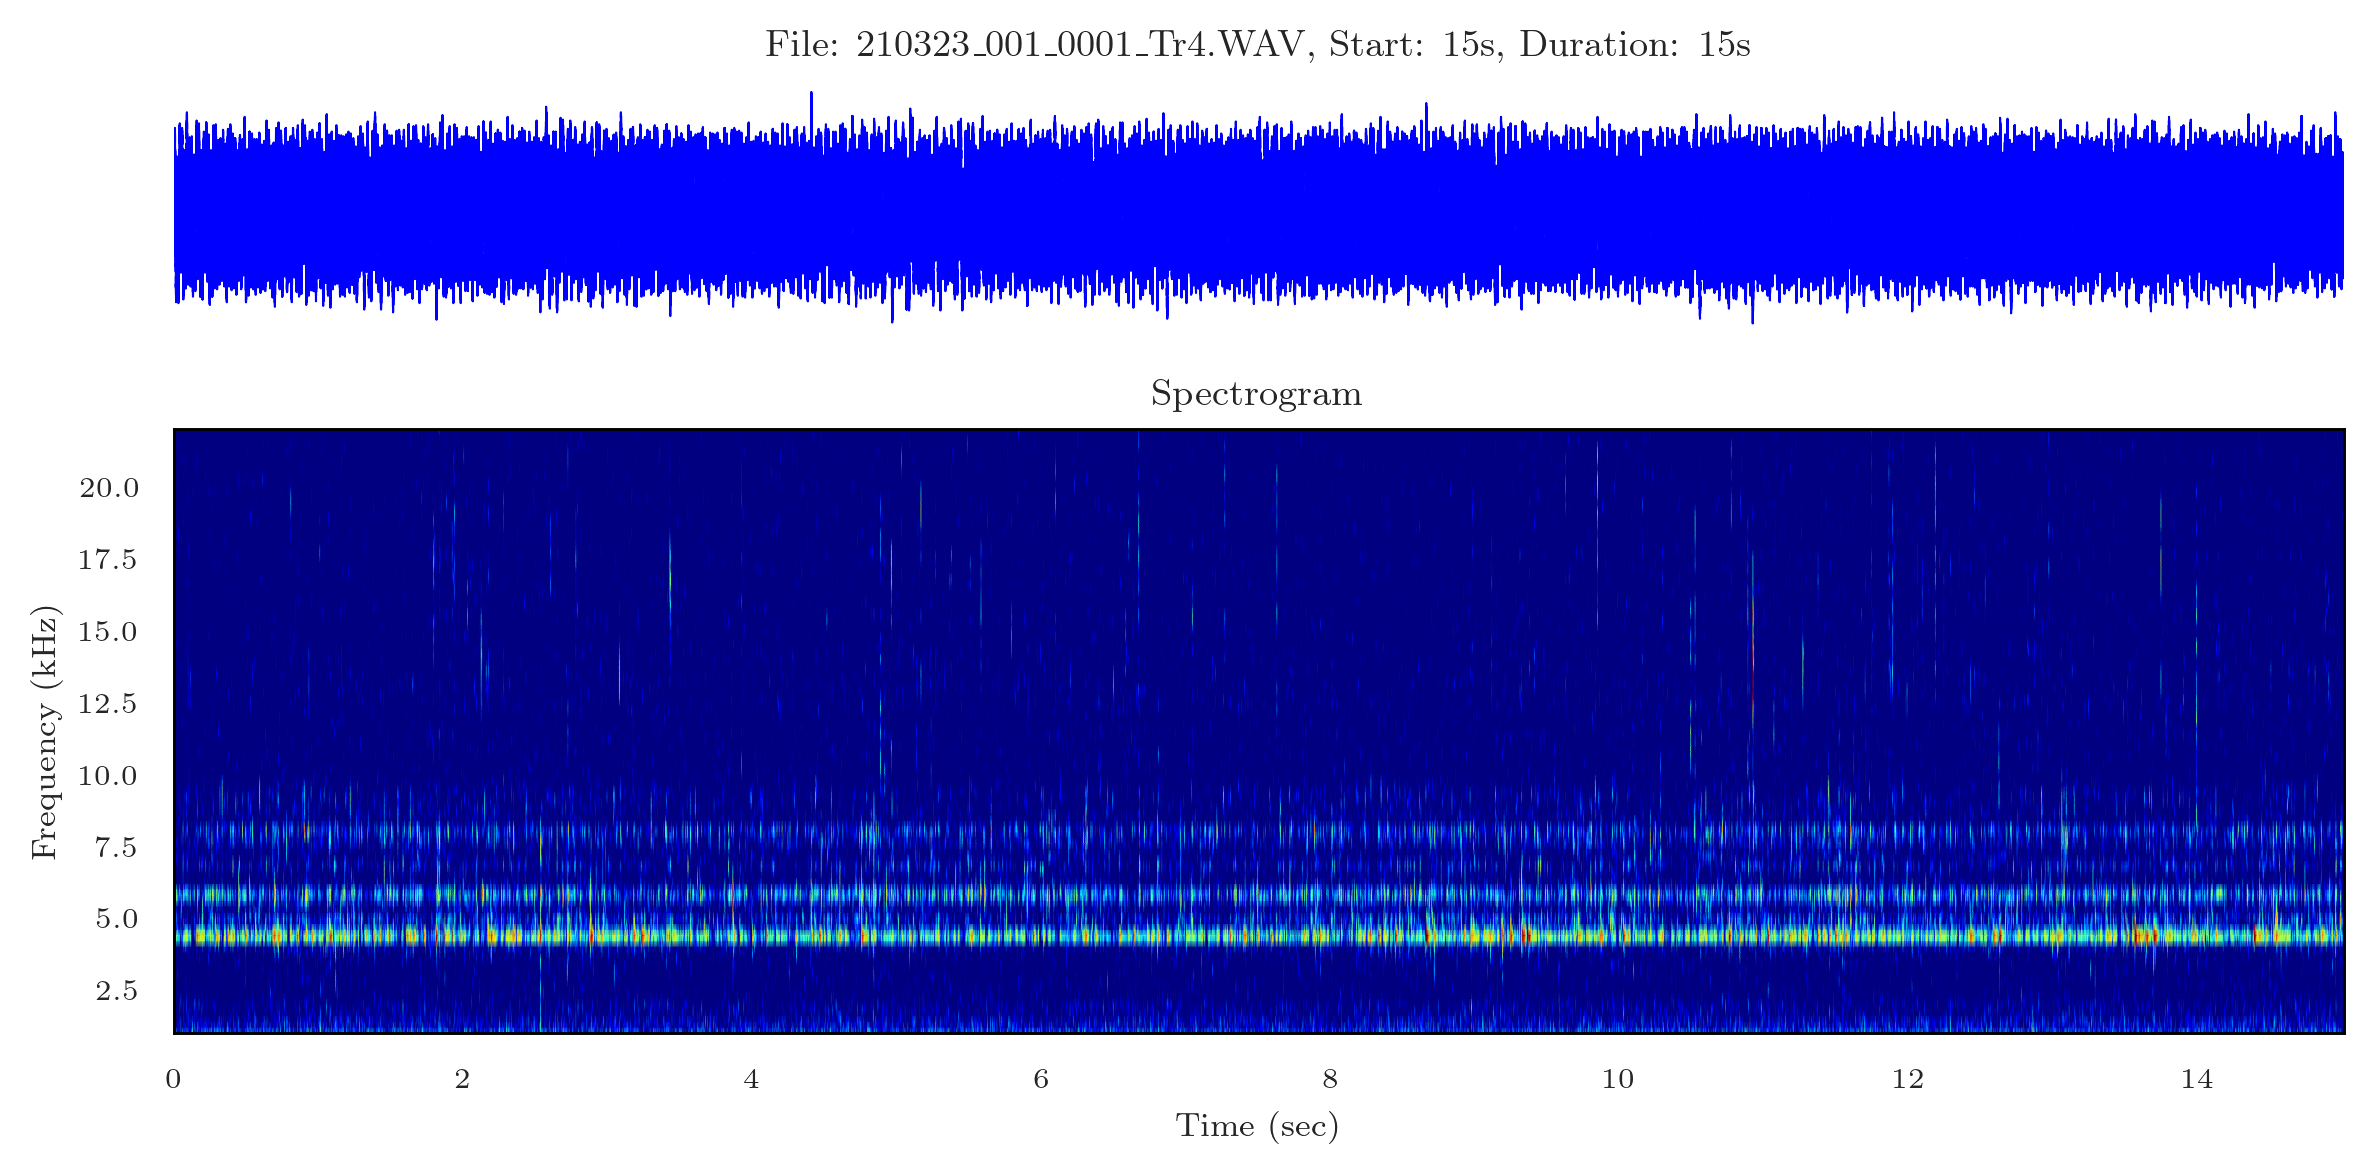

In [5]:
# Plot time istants of the click occrurence

fig = plt.figure(figsize=(8, 4))
ax1 = plt.subplot2grid((3, 1), (0, 0))
ax2 = plt.subplot2grid((3, 1), (1, 0), rowspan=2)
ax1.plot(t, x, color='b',linewidth=0.5, label = 'signal segment')
ax1.set_xlim(t[0], t[-1])
#ax1.legend(loc='upper left', fontsize = 6)
ax1.axis('off')
title_str = f"File: {filename}, Start: {start_time:.0f}s, Duration: {duration:.0f}s"
ax1.set_title(title_str)

plot_spectrogram('Spectrogram', tt, freqs_onesided[idx_fselection], Sxx[idx_fselection,:], 'jet', ax2,  Scale = True, clim=True)

# Adjust layout and save the figure
fig.tight_layout()
# FigName = f'SampleSound_{duration}s.png'
# plt.savefig(os.path.join(save_path, FigName))  # Assuming save_path is defined
plt.show()

In [48]:
# Compute ODFs
f_low = 15e3
f_high = 45e3


band_mask = (freqs_onesided >= f_low) & (freqs_onesided <= f_high)
Sxx_band = Sxx[band_mask, :] 
# Compute ODFs
dHFC = compute_hfc(Sxx_band)
SF = compute_spectral_flux(Sxx_band)
# WPD = compute_wpd(STFT_oneside)
# CD = compute_cd(STFT_oneside)

# Composite ODF
z = np.log10(dHFC * SF  + 1)
threshold = 0.003
detection = z >= threshold

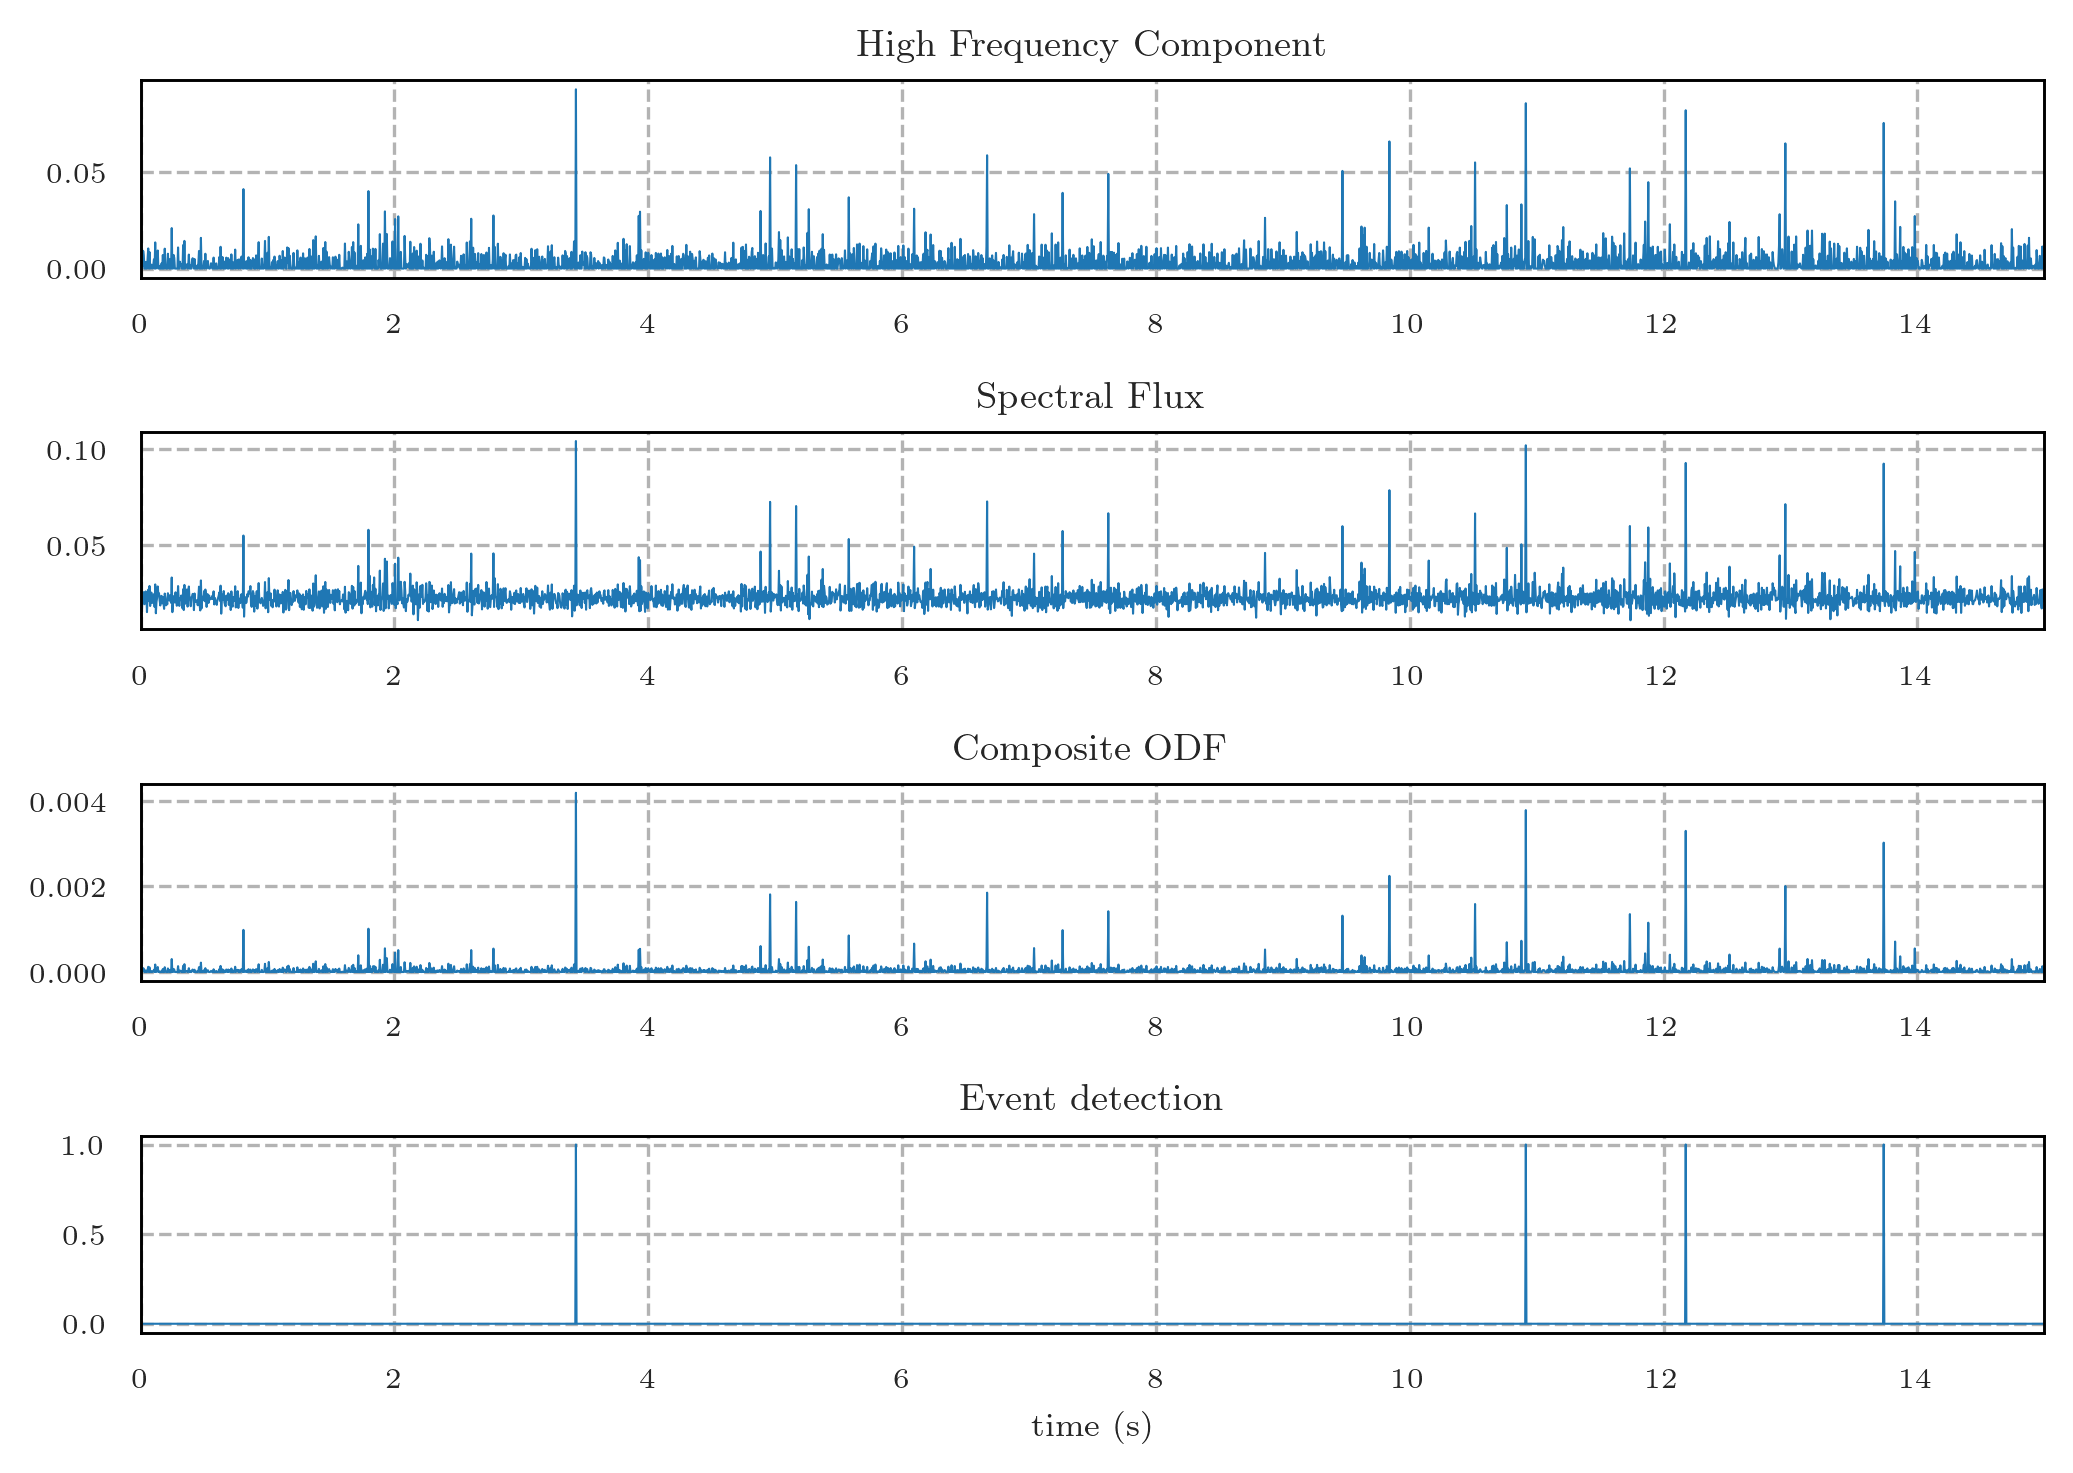

In [49]:
# Plot ODFs

fig,axs = plt.subplots(nrows = 4, figsize = (7,5))

odfs = [dHFC, SF, z, detection]#WPD, CD, z]
odf_names = ['High Frequency Component', 'Spectral Flux', 'Composite ODF', 'Event detection']#'Wheigthed Phese Deviation', 'Complex domain', 'Composite ODF']

for idx,ax in enumerate(axs):
    odf = odfs[idx]
    odf_name = odf_names[idx]
    ax.plot(tt,odf, linewidth = 0.5)
    ax.set_title(odf_name)
    ax.set_xlim(tt[0], tt[-1])

ax.set_xlabel('time (s)')
# Adjust layout and save the figure
fig.tight_layout()
plt.show()

## Step-by-Step Test: Click Detection on a Sample WAV File

This section demonstrates the application of the implemented click detection pipeline using a selected `.wav` audio sample. The process involves detection, result saving, aggregation, and visualization. Follow the steps below:

### 1. Apply Click Detection

The first step is to apply the click detection function defined in `src/detection/detect_clicks.py` to a selected `.wav` file. This step performs onset detection and produces the following outputs:

* A `.csv` file containing the time instants of detected events.
* A `.meta` file that stores the duration (in seconds) of the processed audio file. This is useful for aligning segments in long or concatenated recordings.

### 2. Aggregate Detection Results

After detecting clicks in the audio sample, the next step involves applying the aggregation functions. These functions group individual click events into fixed-length time windows (e.g., 1-second or 5-second intervals) to quantify click activity over time.

### 3. Visualize and Compare Results

Finally, aggregated detection results are visualized and compared with manually annotated reference data (e.g., annotations from Raven). This comparison allows us to assess the performance and accuracy of the implemented detection method.

#### Based on obtained results here we will focus on visualizing joint aggregated results 

The steps we will perform:

1. Load joint aggregated detections for model_detections

In [10]:
def aggregate_detections(df, window_size):
    """
    Aggregate detection events into fixed-size time windows.

    Parameters:
    -----------
    df : pd.DataFrame
        Input DataFrame with a column 'Begin Time (s)' indicating the time of each detection event in seconds.
    window_size : int or float
        Size of each aggregation window in seconds.

    Returns:
    --------
    agg_df : pd.DataFrame
        DataFrame with columns:
        - 'start_time_sec': start time of the window (in seconds).
        - 'event_count': number of events detected in that window.
        Windows with no events will appear with event_count = 0.
    """

    # Assign each event to a time window
    df["window_index"] = (df["Begin Time (s)"] // window_size).astype(int)

    # Count number of events per window
    agg_df = df.groupby("window_index").size().reset_index(name="event_count")
    agg_df["start_time_sec"] = agg_df["window_index"] * window_size

    # Create a complete index of all possible windows from min to max
    min_index = 0#df["window_index"].min()
    max_index = df["window_index"].max()
    full_index = pd.DataFrame({"window_index": range(min_index, max_index + 1)})
    full_index["start_time_sec"] = full_index["window_index"] * window_size

    # Merge with actual data and fill missing windows with event_count = 0
    agg_df = pd.merge(full_index, agg_df, on=["window_index", "start_time_sec"], how="left")
    agg_df["event_count"] = agg_df["event_count"].fillna(0).astype(int)

    # Order and format
    agg_df = agg_df[["start_time_sec", "event_count"]]

    return agg_df

def impute_missing_values(df, cols_to_impute, order=2):
    """
    Fill missing values in selected columns using polynomial interpolation.
    
    Parameters:
    -----------
    df : pd.DataFrame
        The input DataFrame containing time series data.
    cols_to_impute : list
        List of column names to apply interpolation.
    order : int, optional
        Order of polynomial interpolation (default is 2).
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with missing values filled.
    """
    df_imputed = df.copy()  # Avoid modifying original data
    
    for col in cols_to_impute:
        # Apply polynomial interpolation for NaNs
        df_imputed[col] = df_imputed[col].interpolate(method='polynomial', order=order, limit_direction='both')

        # Fallback for any remaining NaNs (start/end edges)
        df_imputed[col] = df_imputed[col].bfill().ffill()


    return df_imputed

def apply_filtfilt_smoothing(df, cols_to_smooth, window_size=5):
    """
    Apply a zero-phase moving average filter using filtfilt from SciPy.
    
    Parameters:
    -----------
    df : pd.DataFrame
        The input DataFrame containing time series data.
    cols_to_smooth : list
        List of column names to apply smoothing.
    window_size : int
        The size of the moving average window (default is 5).
    
    Returns:
    --------
    pd.DataFrame
        A DataFrame with smoothed numerical columns.
    """
    df_smoothed = df.copy()  # Avoid modifying original data
    
    # Define the moving average filter kernel (h)
    h = np.ones(window_size) / window_size

    # Apply filtfilt smoothing to each column
    for col in cols_to_smooth:
        df_smoothed[col] = filtfilt(h, 1, df[col], padlen=0)  # padlen=0 avoids edge artifacts

    return df_smoothed


In [52]:
from src.config.config_loader import load_config

FIGURE_DIR = PROJECT_ROOT / "data" / "figures" / 'comparison'

config = load_config()
window_size = config["aggregation"]["window_size"]

# Step 1: Construct main folders path 
model_root = PROJECT_ROOT / "data" / "metadata" / "model_detections"
ref_root = PROJECT_ROOT / "data" / "metadata" / "reference_detections_update"

# Step 2: Define experiment folder
experiment_folder = "Freq_Feeding"

# Step 3: Trial folder
list_rep_folder = [f'8x_Rep{r:02d}' for r in range(1,4)]
y_ref_mean = np.zeros(470)
y_model_mean = np.zeros(470)

for idx,rep_folder in enumerate(list_rep_folder):
    path_joint_csv = model_root / experiment_folder / rep_folder / f'{rep_folder}_joint.csv'
    df_model = pd.read_csv(path_joint_csv)

    df_model = impute_missing_values(df_model, ['event_count'], order=2)
    df_model = apply_filtfilt_smoothing(df_model, ['event_count'], 2)
    print(f'number of point in model detection for {rep_folder}: {len(df_model)}')

    # Load respective reference detection
    path_ref_detection_csv = ref_root / f'{rep_folder}_detections.csv'
    df_ref_detection = pd.read_csv(path_ref_detection_csv, delimiter = '\t')
    df_ref_detection = df_ref_detection[['Begin Time (s)']]
    df_ref_agg = aggregate_detections(df_ref_detection, window_size)

    # Compute aggregated reference detections
    
    print(f'number of point in reference detection for {rep_folder}: {len(df_ref_agg)}')
    print('\n')

    # Plots
    fig, ax = plt.subplots(1, 1, figsize = (8,4))#, sharey=True, sharex=True)
    t_ref = df_ref_agg["start_time_sec"]/3600
    t_model = df_model["start_time_sec"]/3600

    y_ref = df_ref_agg["event_count"].values
    y_model = df_model["event_count"].values

    y_ref_mean += y_ref[:470]/3
    y_model_mean += y_model[:470]/3

    # Create 1x2 subplot
    ax.plot(t_ref, y_ref, label="Raven", color="purple", linewidth = 0.8)
    ax.plot(t_model, y_model, label="Model", color="tab:blue", linewidth = 0.8)
    ax.set_title(f"Click Activity Comparison: {rep_folder}")
    ax.set_xlabel("Time (h)")
    ax.set_ylabel("Event Count x min")
    ax.grid(False)
    # ax.set_xlim(0,8)
    ax.legend()

    # axs[1].plot(t_model, y_model, label="Model", color="tab:blue")
    # axs[1].set_title("Model Detections")
    # axs[1].set_xlabel("Time (h)")

    # fig.suptitle(f"Click Activity Comparison: {rep_folder}")
    fig.tight_layout()

    # Save figure
    fig_path = FIGURE_DIR / f"{rep_folder}_fL5k-fH22k_Thr0.010.png"
    fig.savefig(fig_path, dpi=300)
    plt.close(fig)

fig, ax = plt.subplots(1, 1, figsize = (8,4))#, sharey=True, sharex=True)
    # Create 1x2 subplot
ax.plot(t_ref[:470], y_ref_mean, label="Mean Raven", color="purple", linewidth = 0.8)
ax.plot(t_model[:470], y_model_mean, label="Mean Model", color="tab:blue", linewidth = 0.8)
ax.set_title(f"Click Activity Comparison: {rep_folder}")
ax.set_xlabel("Time (h)")
ax.set_ylabel("Event Count x min")
ax.grid(False)
# ax.set_xlim(0,8)
ax.legend()

# axs[1].plot(t_model, y_model, label="Model", color="tab:blue")
# axs[1].set_title("Model Detections")
# axs[1].set_xlabel("Time (h)")

# fig.suptitle(f"Click Activity Comparison: {rep_folder}")
fig.tight_layout()

# Save figure
fig_path = FIGURE_DIR / f"Mean-Detections_fL5k-fH22k_Thr0.010.png"
fig.savefig(fig_path, dpi=300)
plt.close(fig)

number of point in model detection for 8x_Rep01: 484
number of point in reference detection for 8x_Rep01: 480


number of point in model detection for 8x_Rep02: 486
number of point in reference detection for 8x_Rep02: 482


number of point in model detection for 8x_Rep03: 480
number of point in reference detection for 8x_Rep03: 471




In [14]:
# Notebook cell
from pathlib import Path
from src.config.config_loader import load_config
from src.detection.click_detection_utils import detect_clicks, save_detection_results

# Step 1: Load configuration
config = load_config()

# Step 2: Define input WAV file
experiment_folder = "Freq_Feeding"
trial_folder = "8x_Rep01"
filename = "210323_001_0001_Tr4.WAV"
file_path = get_wav_path(experiment_folder, trial_folder, filename)

# Step 3: Detect click events
df_events = detect_clicks(file_path, config)

# Step 4: Construct output path (no changes needed in save_detection_results)
output_root = PROJECT_ROOT / "data" / "metadata" / "model_detections"
relative_subfolder = Path(experiment_folder) / trial_folder
output_filename = Path(f"{Path(filename).stem}_events.csv")
output_csv = output_root / relative_subfolder / output_filename
save_detection_results(df_events, output_csv, wav_path=file_path)


In [15]:
output_root

WindowsPath('D:/ShrimpOnsetDetection-Pipeline/Onset-Shrimp-Detection/data/metadata/model_detections')

In [16]:
from src.aggregation.aggregate_detections import aggregate_event_file
from src.config.config_loader import load_config

config = load_config()
window_size = config["aggregation"]["window_size"]
window_size = 60

# Use the same output_csv you generated earlier
# Step 4: Construct output path (no changes needed in save_detection_results)
output_root = PROJECT_ROOT / "data" / "metadata" / "reference_detections"
relative_subfolder = Path(experiment_folder) / trial_folder
output_filename = Path(f"{Path(filename).stem}_events.csv")
output_csv = output_root / relative_subfolder / output_filename
aggregate_event_file(events_csv_path=output_csv, window_size=window_size)


[Info] Aggregated file saved to: D:\ShrimpOnsetDetection-Pipeline\Onset-Shrimp-Detection\data\metadata\reference_detections\Freq_Feeding\8x_Rep01\210323_001_0001_Tr4_aggregated.csv
